In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import squidpy as sq
import spatialdata as sd
import seaborn as sns
import scipy.sparse as sp
from scipy.stats import ttest_rel

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore")


/home/cgobet/miniconda3/envs/spatial/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/cgobet/miniconda3/envs/spatial/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# Import custom plotting helpers
import sys
sys.path.insert(0, "/workspaces/cgobet/2026_06_01_spatial_exploratory/CoPhaser/paper/code/set_up")
import plot_helpers
import constants

# %%
from CoPhaser import plotting

### Load Data


In [4]:
path = '/data/cgobet/2026_06_01_spatial_exploratory/data/'

# Load spatial data
sdata_spatch = sd.read_zarr(os.path.join(path, "spatch/xenium_ovary_spatch.zarr"))
sdata_10x = sd.read_zarr(os.path.join(path, "10x/xenium_ovary_10x.zarr"))

# Load processed anndata
adata = sc.read_h5ad(os.path.join(path, 'xenium_ovary_both_processed.h5ad'))

# Load rhythmic dataframe
df_rhythmic = pd.read_pickle(os.path.join(path, 'df_rhythmic.pkl'))

### Extract Color Schemes

In [6]:
# Get cell type colors from AnnData
cell_type_categories = adata.obs['cell_type'].cat.categories
cell_type_colors = adata.uns['cell_type_colors']
color_dict = dict(zip(cell_type_categories, cell_type_colors))

# Tumor-specific colors
tumor_colors = {
    "Tumor (1)": "#e31a1c",
    "Tumor (2)": "#fb9a99",
    "Tumor (3)": "#a50f15"
}


### Update Spatial Data Tables

In [7]:
def update_sdata_table(adata, sdata, dataset_name):

    from spatialdata.models import TableModel
    
    # Extract dataset-specific cells
    adata_subset = adata[adata.obs['dataset'] == dataset_name].copy()
    
    # Prepare for SpatialData
    adata_subset.obs.index = adata_subset.obs['cell_id'].astype(str)
    adata_subset.obs['instance_id'] = adata_subset.obs.index
    adata_subset.obs['region'] = "cell_boundaries"
    adata_subset.obs['region'] = adata_subset.obs['region'].astype('category')
    
    # Remove redundant cell_id column
    if 'cell_id' in adata_subset.obs.columns:
        adata_subset.obs = adata_subset.obs.drop(columns=['cell_id'])
    
    # Parse as TableModel
    adata_subset = TableModel.parse(
        adata_subset,
        region="cell_boundaries",
        region_key="region",
        instance_key="instance_id"
    )
    
    # Update spatial data
    sdata['table'] = adata_subset
    
    print(f"Updated {dataset_name} table: {adata_subset.shape}")
    return sdata

sdata_spatch = update_sdata_table(adata, sdata_spatch, 'spatch')
sdata_10x = update_sdata_table(adata, sdata_10x, '10x')

Updated spatch table: (372113, 4929)
Updated 10x table: (1062506, 4929)


### Create Supplementary Figure Layout


height_ratios_scaling: [2, 3, 2, 2, 2]


{'A': <Axes: label='A'>,
 'B': <Axes: label='B'>,
 'C': <Axes: label='C'>,
 'D': <Axes: label='D'>,
 'E': <Axes: label='E'>,
 'F': <Axes: label='F'>,
 'G': <Axes: label='G'>,
 'H': [<Axes: >, <Axes: >, <Axes: >],
 'I': [<Axes: >, <Axes: >, <Axes: >]}

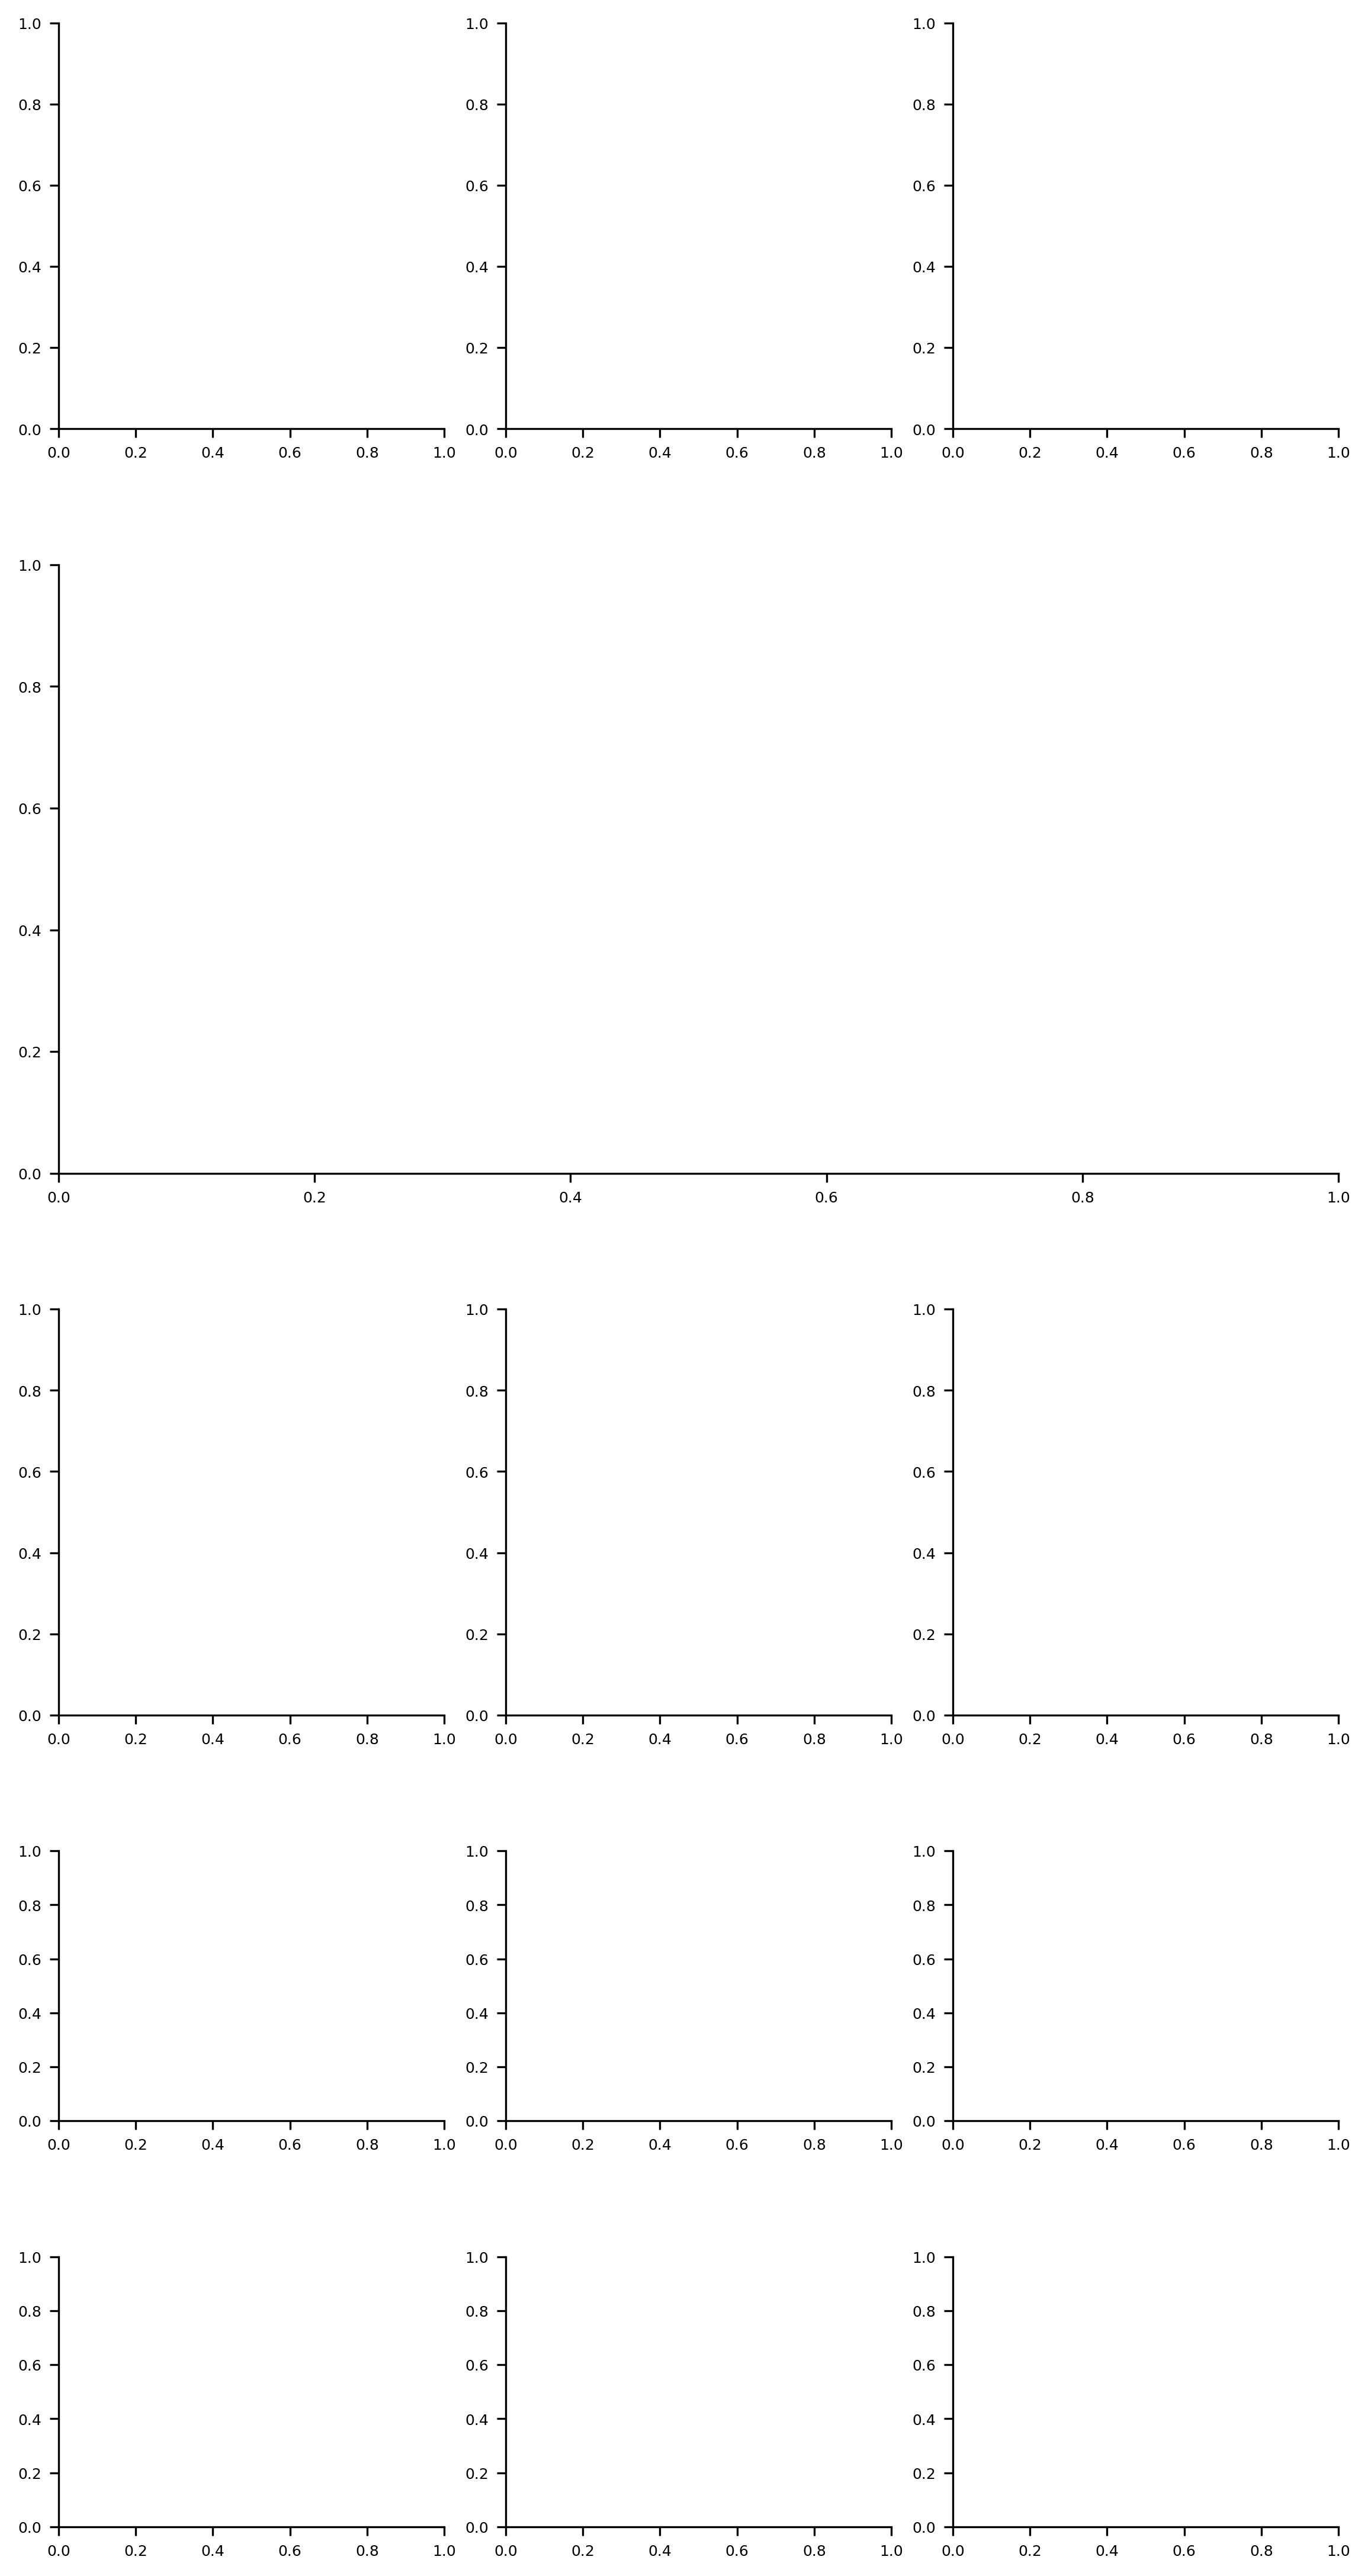

In [9]:
mosaic_s = [["A","B","C"], ["D","D"], ["E","F","G"], ["H","H","H"],["I","I","I"]]
fig_s, axs_s = plot_helpers.create_pannels(mosaic=mosaic_s)
plot_helpers.replace_mosaic_cell_with_grid(fig_s, axs_s, 'H', nrows=1, ncols=3)
plot_helpers.replace_mosaic_cell_with_grid(fig_s, axs_s, 'I', nrows=1, ncols=3)

### Panel A: Cell Cycle Polar Plot

In [10]:
plot_helpers.make_polar(axs_s,'A')
plotting.plot_cell_cycle(df_rhythmic, ax=axs_s['A'])

### Panels B-C: Cell Size and Total Transcript Count

In [11]:
plotting.plot_smoothed_profiles(x= adata.obs["inferred_theta"], y=adata.obs["cell_area"], hue=adata.obs['dataset'], ax=axs_s['B'])
plotting.modify_axis_labels(ax=axs_s['B'], step=0.5)
axs_s['B'].set_title('Cell Area vs. Inferred Phase')
axs_s['B'].set_ylabel('Cell Area')
axs_s['B'].set_xlabel('Inferred Phase')


plotting.plot_smoothed_profiles(x= adata.obs["inferred_theta"], y=adata.obs["library_size"], hue=adata.obs['dataset'], ax=axs_s['C'])
plotting.modify_axis_labels(ax=axs_s['C'], step=0.5);
axs_s['C'].set_title('#Transcripts vs. Inferred Phase')
axs_s['C'].set_ylabel('#Transcripts')
axs_s['C'].set_xlabel('Inferred Phase')

Text(0.5, 3556.8181818181824, 'Inferred Phase')

### Panel D: Cell Type Marker Genes

In [12]:
marker_genes = {
    "Tumor (1)": ["EPCAM", "MUC1", "MUC16"],
    "Tumor (2)": ["KLK6", "KLK10", "IGFBP2"],
    "Tumor (3)": ["LAMA3", "ST14", "PROM1"],
    "T": ["CD3E", "ZAP70", "CD247"],
    "Plasma": ["MZB1", "XBP1", "CD79A"],
    "Mac. (M1-like)": ["CD14", "CD68", "ITGAX"],
    "Mac. (M2-like)": ["CD163", "MRC1", "STAB1"],
    "CAFs": ["FAP", "POSTN", "COL10A1"],
    "Fibroblasts": ["PDGFRA", "TCF21", "TNXB"],
    "Endothelial": ["PECAM1", "CDH5", "KDR"],
    "Unassigned": ["ZNF683", "CYP17A1"]
}

sc.pl.dotplot(
    adata, 
    marker_genes, 
    groupby='cell_type', 
    standard_scale='var', 
    smallest_dot=1,
    title="",
    colorbar_title="",
    show=True,       
    dendrogram=False,
    ax=axs_s['D']
  
)


### Panels E-F: UMAP 

In [13]:
sc.pl.umap(
    adata, 
    color=['dataset'], 
    size=0.2, 
    alpha=0.1, 
    wspace=0.2, 
    ax=axs_s['E'], 
    legend_loc=None,    
    show=False
)

sc.pl.umap(
    adata, 
    color=['cell_type'], 
    size=0.2, 
    alpha=0.1, 
    wspace=0.2, 
    ax=axs_s['F'], 
    legend_loc=None,    
    show=False
)

<Axes: label='F', title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

### Panel G: Cell Type Composition by Dataset

In [14]:
proportions = pd.crosstab(adata.obs['dataset'], adata.obs['cell_type'], normalize='index')
plot_colors = [color_dict[column] for column in proportions.columns]

proportions.plot(
    kind='bar', 
    stacked=True, 
    ax=axs_s['G'],           
    width=0.4,
    edgecolor='white',
    color=plot_colors
)

axs_s['G'].set_ylabel('Fraction of Cells', fontsize=10)
axs_s['G'].set_xlabel('')
axs_s['G'].legend(
    title='', 
    bbox_to_anchor=(0.5, 0.5), 
    loc='center left', 
    frameon=False,
    fontsize=8
)

axs_s['G'].tick_params(axis='x', rotation=45)
for tick in axs_s['G'].get_xticklabels():
    tick.set_ha('right')

axs_s['G'].grid(axis='y', linestyle='--', alpha=0.3)
axs_s['G'].xaxis.label.set_visible(False)

### Compute Spatial Neighborhoods

In [15]:
sq.gr.spatial_neighbors(sdata_10x['table'], coord_type="generic", delaunay=True)
sq.gr.spatial_neighbors(sdata_spatch['table'], coord_type="generic", delaunay=True)


In [ ]:
sq.gr.nhood_enrichment(sdata_10x['table'], cluster_key="cell_cycle_phase")
sq.gr.nhood_enrichment(sdata_spatch['table'], cluster_key="cell_cycle_phase")

  0%|          | 0/1000 [00:00<?, ?/s]

### Panels H-I: Spatial Clustering Analysis (Phase Patches)

In [ ]:
def analyze_paired_clustering(sdata, target_cell_type, min_cluster_size=100, n_permutations=100):
    """Analyze spatial clustering of cell cycle phases within a cell type cluster."""
    adj = sdata['table'].obsp['spatial_connectivities']
    obs = sdata['table'].obs[['cell_type', 'cell_cycle_phase']].copy()
    cycling_phases = ['G1/S', 'S', 'G2/M']
    
    ct_indices = np.where(obs['cell_type'] == target_cell_type)[0]
    ct_adj = adj[ct_indices, :][:, ct_indices]
    _, labels = sp.csgraph.connected_components(ct_adj, directed=False)
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    valid_labels = unique_labels[counts >= min_cluster_size]
    
    paired_data = []

    def get_mean_patch(phase_mask, adjacency):
        p_idx = np.where(phase_mask)[0]
        if len(p_idx) == 0: return 0
        sub_adj = adjacency[p_idx, :][:, p_idx]
        _, p_labels = sp.csgraph.connected_components(sub_adj, directed=False)
        return np.mean(np.unique(p_labels, return_counts=True)[1])

    for lab in valid_labels:
        cluster_indices = ct_indices[labels == lab]
        c_obs = obs.iloc[cluster_indices].copy()
        c_adj = adj[cluster_indices, :][:, cluster_indices]
        
        is_cycling = c_obs['cell_cycle_phase'].isin(cycling_phases)
        cycling_locs = np.where(is_cycling)[0]
        
        for phase in cycling_phases:
            obs_mean = get_mean_patch((c_obs['cell_cycle_phase'] == phase).values, c_adj)
            
            null_means = []
            for _ in range(n_permutations):
                shuffled = c_obs.loc[is_cycling, 'cell_cycle_phase'].values.copy()
                np.random.shuffle(shuffled)
                temp = c_obs['cell_cycle_phase'].values.copy()
                temp[cycling_locs] = shuffled
                null_means.append(get_mean_patch(temp == phase, c_adj))
            
            paired_data.append({
                'cluster_id': lab,
                'phase': phase,
                'observed': obs_mean,
                'null_expected': np.mean(null_means)
            })

    return pd.DataFrame(paired_data)

def analyze_all_tumors(sdata, tumor_list, n_perms=100):
    all_results = []
    for tumor in tumor_list:
        print(f"Processing {tumor}...")
        df_paired = analyze_paired_clustering(sdata, tumor, min_cluster_size=100, n_permutations=n_perms)
        df_paired['tumor_type'] = tumor
        all_results.append(df_paired)
    return pd.concat(all_results)


def plot_tumor_row(full_df, tumor_types, axes_row, title_prefix="", tumor_colors=None):
    axes_row = list(axes_row)
    y_limit = full_df['observed'].max() * 1.15
    
    for i, tumor in enumerate(tumor_types):
        ax = axes_row[i]
        df_sub = full_df[full_df['tumor_type'] == tumor]
        df_plot = df_sub.melt(id_vars=['cluster_id', 'phase', 'tumor_type'], 
                              value_vars=['observed', 'null_expected'],
                              var_name='Group', value_name='Mean_Patch_Size')
        
        current_palette = {"observed": tumor_colors[tumor], "null_expected": "#999999"}
        
        sns.boxplot(data=df_plot, x='phase', y='Mean_Patch_Size', hue='Group', 
                    ax=ax, palette=current_palette, showfliers=False, boxprops=dict(alpha=0.2))
        sns.stripplot(data=df_plot, x='phase', y='Mean_Patch_Size', hue='Group', 
                      ax=ax, palette=current_palette, dodge=True, alpha=0.7, size=1, legend=False)
        
        ax.set_title(f"{title_prefix} {tumor}", fontsize=8, loc='left', fontweight='bold', 
                     color=tumor_colors[tumor], pad=15)
        
        ax.set_ylim(0, y_limit)
        ax.set_xlabel("")
        ax.set_ylabel("Mean Patch Size" if i == 0 else "")

        for j, phase in enumerate(['G1/S', 'S', 'G2/M']):
            stats_sub = df_sub[df_sub['phase'] == phase]
            if len(stats_sub) > 1:
                _, p = ttest_rel(stats_sub['observed'], stats_sub['null_expected'])
                sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
                ax.text(j, y_limit * 0.95, f"{sig}\np={p:.3f}", 
                        ha='center', va='top', fontsize=8, color="#333333")
        
        ax.get_legend().remove()
        sns.despine(ax=ax)



Processing Tumor (1)...
Processing Tumor (2)...
Processing Tumor (3)...
Processing Tumor (1)...
Processing Tumor (2)...
Processing Tumor (3)...


In [ ]:
#run analysis for all tumor cells
tumor_types = ["Tumor (1)", "Tumor (2)", "Tumor (3)"]
tumor_colors = {
    "Tumor (1)": "#e31a1c",
    "Tumor (2)": "#fb9a99",
    "Tumor (3)": "#a50f15"
}

full_df_10x = analyze_all_tumors(sdata_10x, tumor_types, n_perms=1)
full_df_spatch = analyze_all_tumors(sdata_spatch, tumor_types, n_perms=1)

axes_10x = axs_s['H']
axes_spatch = axs_s['I']

# Plot results
plot_tumor_row(full_df_10x, tumor_types, axes_10x, title_prefix="10x:", tumor_colors=tumor_colors)
plot_tumor_row(full_df_spatch, tumor_types, axes_spatch, title_prefix="Ren et al.:", tumor_colors=tumor_colors)

handles, labels = axes_10x[0].get_legend_handles_labels()

### Finalize and Save Figure

Figure saved to: /workspaces/cgobet/2026_06_01_spatial_exploratory/plot/figure_spatial_sup.svg


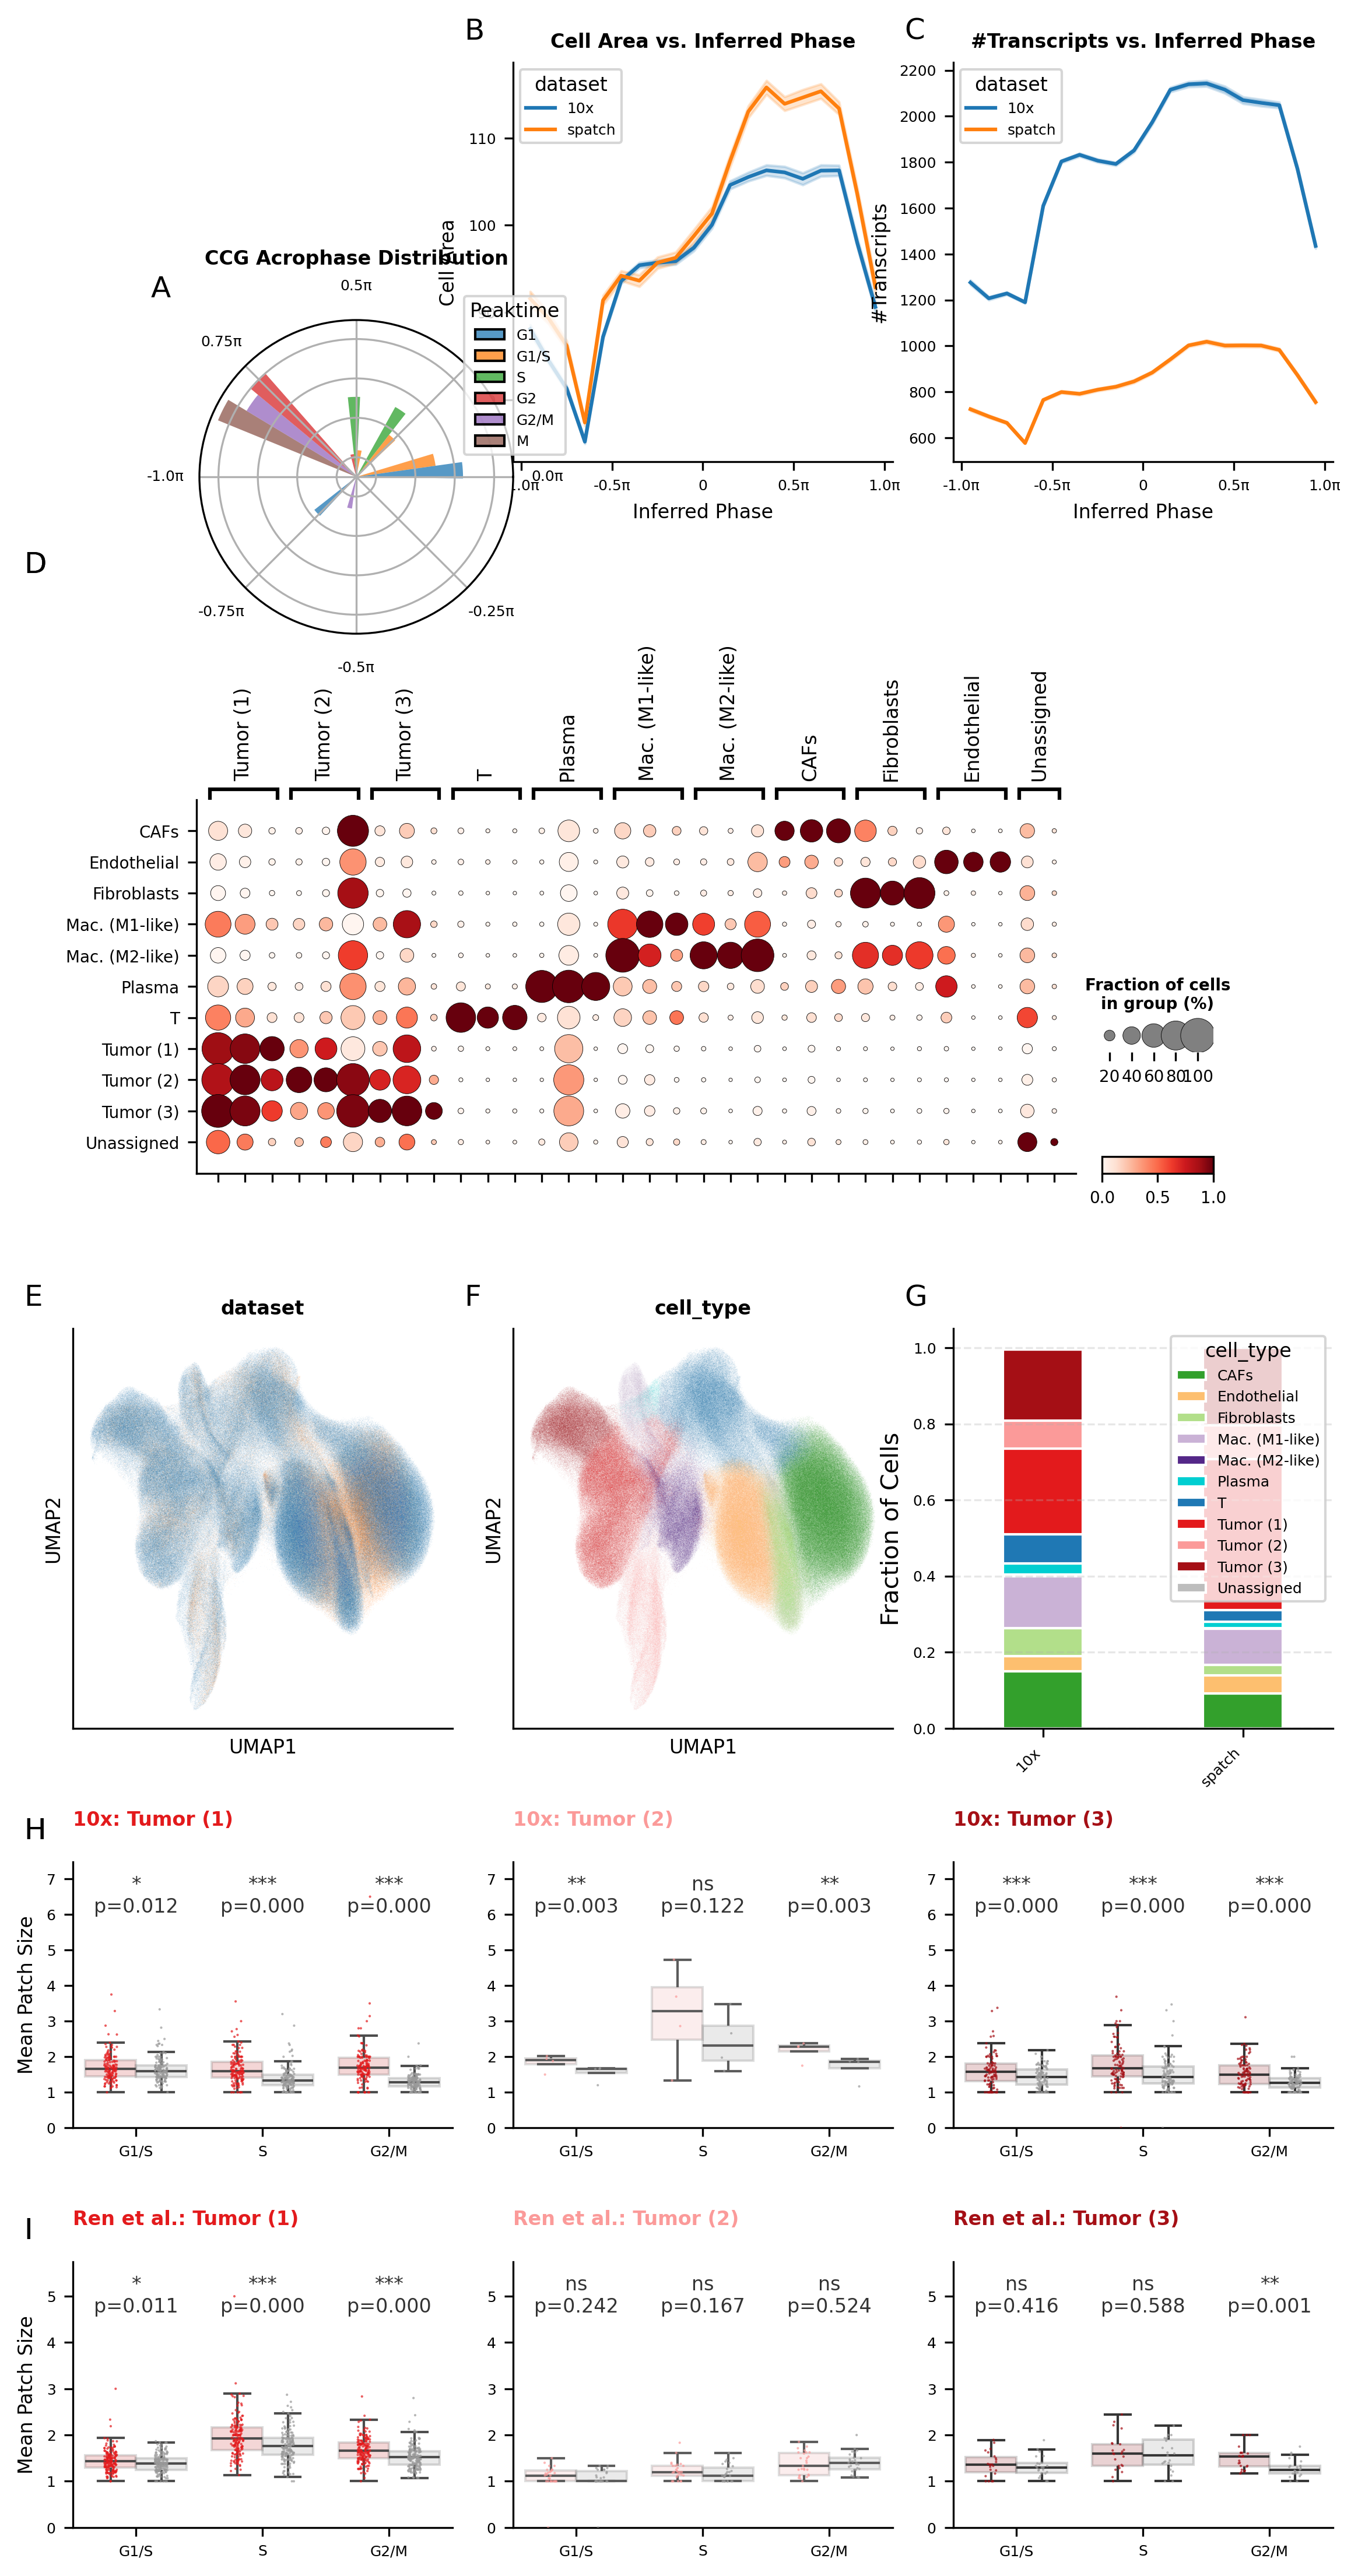

In [ ]:
plot_helpers.label_panels_mosaic(fig_s, axs_s, mosaic=mosaic_s)
plot_helpers.save_figure(fig_s, axs_s, "Figure_Spatial_Sup", path, mosaic=mosaic_s)